In [92]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import numpy

In [93]:
pe_file = '/g/data/r87/dbi599/CMIP5/CMIP/NOAA-GFDL/GFDL-CM3/historical/r1i1p1/Ayr/pe/gn/v20120227/pe-zonal-sum_Ayr_GFDL-CM3_historical_r1i1p1_1860-2005.nc'
pe_cube = iris.load_cube(pe_file, 'precipitation minus evaporation flux') 

In [111]:
lat_coord = pe_cube.coord('latitude').points
print(lat_coord)

[-89. -87. -85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63.
 -61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35.
 -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.
  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.
  23.  25.  27.  29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.
  51.  53.  55.  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.
  79.  81.  83.  85.  87.  89.]


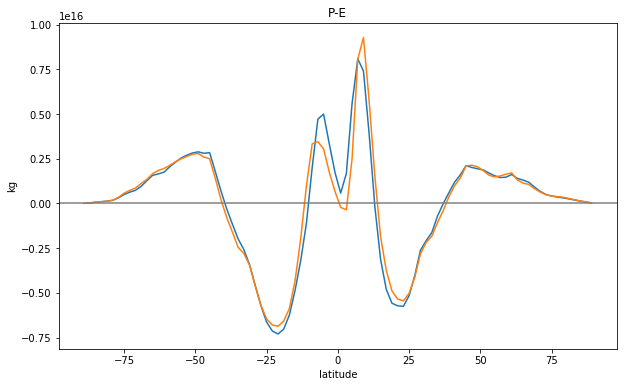

In [96]:
plt.figure(figsize=[10, 6])
iplt.plot(pe_cube[0, :])
iplt.plot(pe_cube[3, :])
plt.axhline(y=0.0, color='0.5', linestyle='-')
plt.xlabel('latitude')
plt.ylabel('kg')
plt.title('P-E')
plt.show()\

### Budget closure

In [97]:
pe_cube[0, :].data[pe_cube[0, :].data > 0].sum()

1.0415877e+17

In [98]:
pe_cube[0, :].data[pe_cube[0, :].data < 0].sum()

-1.0456659e+17

### Regional accumulation

In [106]:
def get_boundary_indexes(xintercept_indexes, lat_coord):
    """Find boundary indexes in x-intercepts"""
    
    sh_southern_boundary = None
    sh_northern_boundary = None
    for index in xintercept_indexes:
        lat = lat_coord[index]
        if (lat < -25) and (lat > -50) and not sh_southern_boundary:
            sh_southern_boundary = index
        if (lat < -7) and (lat > -25) and not sh_northern_boundary:
            sh_northern_boundary = index
        if sh_southern_boundary and sh_northern_boundary:
            break

    nh_southern_boundary = None
    nh_northern_boundary = None
    for index in reversed(xintercept_indexes):
        lat = lat_coord[index]
        if (lat > 25) and (lat < 50) and not nh_northern_boundary:
            nh_northern_boundary = index
        if (lat > 7) and (lat < 25) and not nh_southern_boundary:
            nh_southern_boundary = index
        if nh_southern_boundary and nh_northern_boundary:
            break

    assert (lat_coord[sh_southern_boundary] < -25) and (lat_coord[sh_southern_boundary] > -50)
    assert (lat_coord[sh_northern_boundary] < -7) and (lat_coord[sh_northern_boundary] > -25)
    assert (lat_coord[nh_southern_boundary] > 7) and (lat_coord[nh_southern_boundary] < 25)
    assert (lat_coord[nh_northern_boundary] > 25) and (lat_coord[nh_northern_boundary] < 50)
    
    return sh_southern_boundary, sh_northern_boundary, nh_southern_boundary, nh_northern_boundary


def get_regional_totals(pe_data, lat_coord):
    """Calculate the P-E zonally integrated regional totals.
    
    pe_data (numpy.array) - one dimensional (latitude) data array
    
    """

    pair_products = pe_data[0:-1] * pe_data[1:]
    xintercept_indexes = numpy.where(pair_products < 0)[0] + 1
    boundary_indexes = get_boundary_indexes(xintercept_indexes, lat_coord)
    
    sh_precip = pe_data[0:boundary_indexes[0]].sum()
    sh_evap = pe_data[boundary_indexes[0]:boundary_indexes[1]].sum()
    tropical_precip = pe_data[boundary_indexes[1]:boundary_indexes[2]].sum()
    nh_evap = pe_data[boundary_indexes[2]:boundary_indexes[3]].sum()
    nh_precip = pe_data[boundary_indexes[3]:].sum()

    return sh_precip, sh_evap, tropical_precip, nh_evap, nh_precip

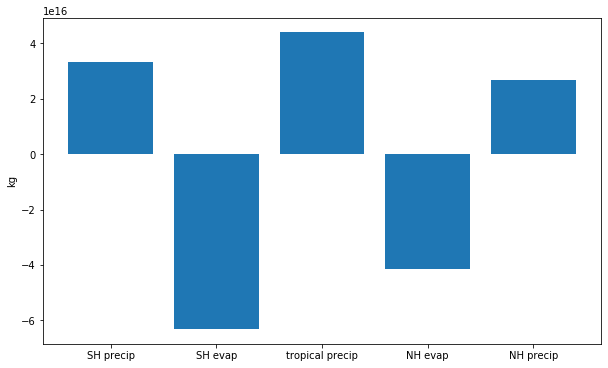

In [113]:
plt.figure(figsize=[10, 6])
yvals = get_regional_totals(pe_cube.data[0, :], lat_coord)
xvals = [0, 1, 2, 3, 4]
plt.bar(xvals, yvals)
plt.ylabel('kg')
plt.xticks(xvals, ['SH precip', 'SH evap', 'tropical precip', 'NH evap', 'NH precip'])
plt.show()

In [114]:
region_timeseries = numpy.apply_along_axis(get_regional_totals, 1, pe_cube.data, lat_coord)

In [115]:
region_timeseries.shape

(146, 5)

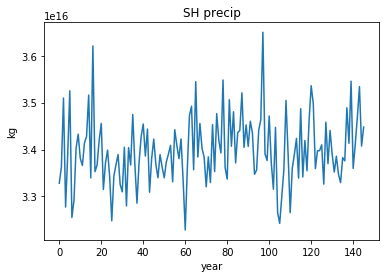

In [123]:
plt.plot(region_timeseries[:, 0])
plt.title('SH precip')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

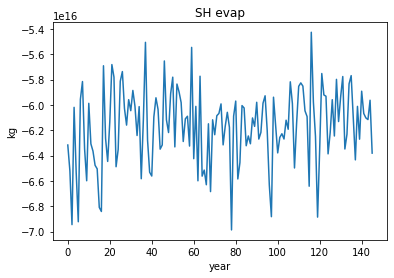

In [121]:
plt.plot(region_timeseries[:, 1])
plt.title('SH evap')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

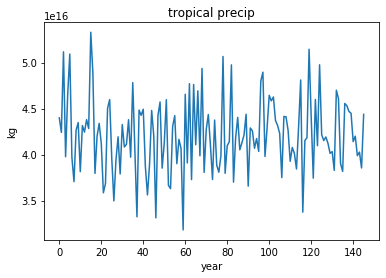

In [124]:
plt.plot(region_timeseries[:, 2])
plt.title('tropical precip')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

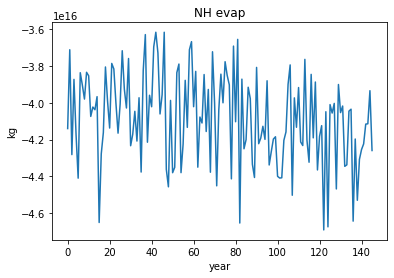

In [122]:
plt.plot(region_timeseries[:, 3])
plt.title('NH evap')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()

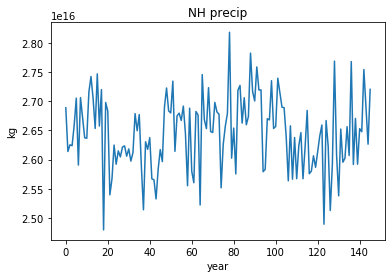

In [125]:
plt.plot(region_timeseries[:, 4])
plt.title('NH precip')
plt.ylabel('kg')
plt.xlabel('year')
plt.show()